# Discrete Event Simulation of a  Battery Shipping Queue

In the notebook below, we explore the behavior of a simplistic battery shipping queue. First, we will demonstrate this through a rudimentary fixed time progression and then through next-event time progression using SimPy.

Our basic assumptions for this example will be that shipping time for each battery is constant (10 hours for a delivery truck to take a battery to its destination and become available again) and battery demand/times at which batteries are ready to ship are modeled randomly uniform over the simulation time.

In [8]:
import numpy as np

# set a battery shipping time--suppose 10 hours
BATTERY_SHIPPING_TIME = 10

# define shipping/installation simulation function which returns our queue length over time
def simulate_battery_shipment(num_delivery_trucks, time_span, num_batteries):
    
    # assign placeholder values for queue length, truck availability times
    battery_q_len = 0
    truck_time_until_free = [0 for _ in range(num_delivery_trucks)]
    
    # create empty lists for queue lengths over time
    battery_q_len_over_time = []
    
    # set times at which batteries are available modeled a uniform random variable
    np.random.seed(30)
    battery_ready_to_ship_times = sorted(np.round(np.random.uniform(0, time_span, num_batteries)))
    
    # iterate over simulation's arbitraty time span
    for interval in range(time_span):
        
        # is a battery available for a truck to ship?
        if battery_ready_to_ship_times and battery_ready_to_ship_times[0] == interval:
            battery_q_len += 1 # add to queue
            battery_ready_to_ship_times.pop(0) # pop the first ready to ship time from the list
        
        # ship the battery if a truck is available
        for truck in range(num_delivery_trucks):
            # check that the truck is free
            if truck_time_until_free[truck] == 0:
                # decrement the queue length and set the trucks time left to complete shipment
                # if a truck can take a battery
                if battery_q_len > 0:
                    battery_q_len -= 1
                    truck_time_until_free[truck] = BATTERY_SHIPPING_TIME - 1 # -1 here in order to facilitate immediate turnaround; otherwise there is an hour of in between time     
                    
            else:
                # decrement time until the truck is free if it isn't available
                truck_time_until_free[truck] -= 1
        
        # append the current queue length to the over-time list
        battery_q_len_over_time.append(battery_q_len)
    
    return battery_q_len_over_time

# set simulation length in hours and the number of batteries to ship
sim_time = 48
battery_count = 15

## What happens with 1, 2, 3, 4... delivery trucks available?

We see that the queue of batteries waiting to ship grows over time with 1, 2, and 3 delivery trucks to meet battery demand and there are still batteries waiting in queue come the end of our 48 hour simulation. Situations like these could rise to unnecessary costs assuming that items sitting in inventory outweights the costs of more delivery trucks until a certain point. However, once there are at least 4 delivery trucks available to meet battery demand, we never incur a queue at all. Note that this is specific to the distribution of battery demand and variability about this distribution can cause queue lengths to change over time such that a 4 delivery truck system isn't necessarily immune to preventing a queue in all cases.

1 Truck System Time-Queue Coords: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 3), (19, 3), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 5), (26, 6), (27, 5), (28, 6), (29, 6), (30, 6), (31, 7), (32, 8), (33, 8), (34, 8), (35, 8), (36, 8), (37, 8), (38, 8), (39, 8), (40, 8), (41, 8), (42, 8), (43, 8), (44, 8), (45, 9), (46, 10), (47, 9)]


2 Truck System Time-Queue Coords: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 3), (26, 4), (27, 3), (28, 3), (29, 3), (30, 3), (31, 4), (32, 5), (33, 5), (34, 5), (35, 5), (36, 5), (37, 5), (38, 4), (39, 4), (40, 4), (41, 4), (42, 4), (43, 4), (44, 4), (45, 5), (46, 6), (47, 5)]


3 Truck System Time-Queue Coords: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0)

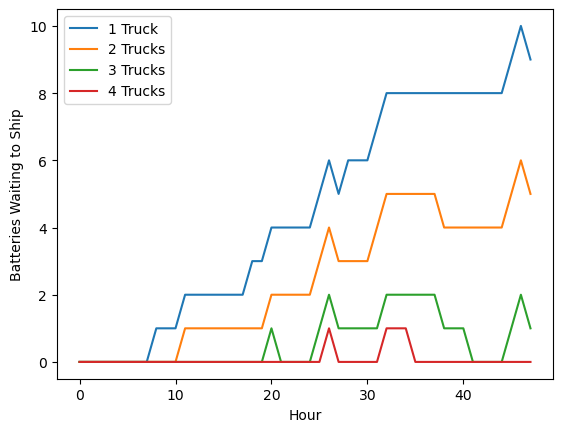

In [9]:
import matplotlib.pyplot as plt

# create an hours array for the x axis
hours = np.arange(0, sim_time, 1)

# plot our batteries waiting to ship against time for 1, 2, 3, and 4 trucks
for i in range(1,5):
    battery_q = simulate_battery_shipment(i, sim_time, battery_count)
    coords = list(zip(hours, battery_q))
    print('%d Truck System Time-Queue Coords: %s' % (i, coords))
    print('\n')
    plt.plot(hours, battery_q)
    plt.xlabel('Hour')
    plt.ylabel('Batteries Waiting to Ship')
    plt.legend(labels=['1 Truck', '2 Trucks', '3 Trucks', '4 Trucks'])

# Structure of a Basic SimPy Model

Creating a general SimPy structure with classes Environment, Event, Timeout and Process with the help of heapq.

In [10]:
import heapq

class Environment:
    def __init__(self):
        self.now = 0
        self.queue = []
        self.event_id = 0
        
    def schedule(self, event, delay=0):
        heapq.heappush(self.queue, (self.now + delay, self.event_id, event))
        self.event_id += 1
        
    def timeout(self, delay, value=True):
        return Timeout(self, delay, value)
        
    def process(self, generator):
        return Process(self, generator)
        
    def run(self):
        while len(self.queue):
            self.now, eid, current_event = heapq.heappop(self.queue)
            for callback in current_event.callbacks:
                callback(current_event)
            
class Event:
    def __init__(self, env):
        self.env = env
        self.value = None
        self.callbacks = []
        
    def succeed(self, value):
        self.value = value
        self.env.schedule(self)
        
class Timeout(Event):
    def __init__(self, env, delay, value=True):
        super().__init__(env)
        self.delay = delay
        self.value = value
        self.env.schedule(self, self.delay)
        
class Process(Event):
    def __init__(self, env, generator):
        super().__init__(env)
        self.generator = generator
        start = env.timeout(0)
        start.callbacks.append(self.resume)
        
    def resume(self, event):
        if event.value is not None:
            try:
                event = self.generator.send(None)
                event.callbacks.append(self.resume)
            except StopIteration:
                pass
            
env = Environment()

# define processes which print following timeout procedures
def alarm_1(env):
    yield env.timeout(5)
    print(f"{env.now} Alarm 1")
    
def alarm_2(env):
    yield env.timeout(200)
    print(f"{env.now} Alarm 2")
    
env.process(alarm_1(env))
env.process(alarm_2(env))

# Run!
env.run()

5 Alarm 1
200 Alarm 2


## Modeling Shipments with Next-Event Time Progression via SimPy

Now we will leverage SimPy for our battery shipment example by defining processes for our delivery trucks and battery demand. Here we will simply consider the case in which a single delivery truck is handling battery shipments.

In [11]:
import simpy as sp

# define our delivery truck and battery processes
def delivery_truck(env, battery_container):
    while True:
        yield battery_container.get(1) # Grab a Battery from the container
        print("Truck shipping battery at hour: %d" % (env.now))
        print('  Current Battery Queue: %d' % battery_container.level)
        yield env.timeout(BATTERY_SHIPPING_TIME) # time out for shipping duration
        
def batteries_ready(env, battery_container, battery_ready_to_ship_times):
    for time in battery_ready_to_ship_times:
        yield env.timeout(time - env.now) # time out until a battery is ready
        yield battery_container.put(1) # Add a Battery to be ready for shipment
        print("New Battery Available with No Truck at hour: %d" % (env.now))
        print('  Current Battery Queue: %d' % battery_container.level)

# set simulation length in hours and the number of batteries to ship
sim_time = 48
battery_count = 15
        
# set a seed for reproducibility of random uniform variable battery-ready-to-ship-times
np.random.seed(30)        

# set times at which batteries are available modeled a uniform random variable
battery_ready_to_ship_times = sorted(np.round(np.random.uniform(0, sim_time, battery_count)))

# set a simpy environment
env = sp.Environment()

# create a battery container resource
battery_container = sp.Container(env)

# process our battery-ready-to-ship-times and delivery truck departure times
env.process(batteries_ready(env, battery_container, battery_ready_to_ship_times))
env.process(delivery_truck(env, battery_container))

# Run!
print('Battery Shipment Simulation Process Log:')
print('*'*100)
env.run(until=sim_time)
print('*'*100)

Battery Shipment Simulation Process Log:
****************************************************************************************************
New Battery Available with No Truck at hour: 7
  Current Battery Queue: 0
Truck shipping battery at hour: 7
  Current Battery Queue: 0
New Battery Available with No Truck at hour: 8
  Current Battery Queue: 1
New Battery Available with No Truck at hour: 11
  Current Battery Queue: 2
Truck shipping battery at hour: 17
  Current Battery Queue: 2
New Battery Available with No Truck at hour: 17
  Current Battery Queue: 2
New Battery Available with No Truck at hour: 18
  Current Battery Queue: 3
New Battery Available with No Truck at hour: 20
  Current Battery Queue: 4
New Battery Available with No Truck at hour: 25
  Current Battery Queue: 5
New Battery Available with No Truck at hour: 26
  Current Battery Queue: 6
Truck shipping battery at hour: 27
  Current Battery Queue: 5
New Battery Available with No Truck at hour: 28
  Current Battery Queue: 6


## In the process log above, we see that we've replicated the 1 truck case demonstrated by fixed event time earlier, though now the code is much cleaner and less cumbersome! 

Also noteworthy is that simpy can handle simultaneous arrivals in discrete event simulation whereas the code used for fixed event time progress cannot! To adapt it to do so, it gets much trickier which is just one reason why SimPy is preferable.

# Multi-Truck Battery Shipment SimPy Implementation

In order to simulate multiple trucks being able to ship batteries at once, we'll create a Trucks class as seen below so we can time out individual trucks as they pick up batteries and are unavailable until they finish their shipments.

In [12]:
import simpy as sp
import itertools

class Trucks:
    def __init__(self, env, num_trucks, shipment_time):
        self.env = env
        self.fleet = sp.Resource(env, num_trucks) # set a truck fleet resource
        self.shipment_time = shipment_time

    def ship(self, truck, battery_container):
        battery_container.get(1) # Get a battery for the current truck
        print('  Current Battery Queue: %d' % battery_container.level) # show the current queue length
        yield self.env.timeout(self.shipment_time) # Ship the battery

def battery(env, name, fleet, battery_container):
    with fleet.fleet.request() as req: # hold the truck until shipment is finished
        yield req
        print('%s shipped at Hour %d' % (name, env.now))
        yield env.process(fleet.ship(name, battery_container)) # calling the ship process
        print('%s arrived at Hour %d' % (name, env.now))

def setup(env, num_trucks, shipment_time, battery_container, battery_ready_to_ship_times):
    # battery shippment number
    battery_num = itertools.count()
    
    # Create the truck fleet
    fleet = Trucks(env, num_trucks, shipment_time)

    # Create successive battery arrivals ready to ship while the simulation is running
    for time in battery_ready_to_ship_times:
        yield env.timeout(time - env.now) # wait until the next battery is ready
        battery_container.put(1) # add battery to the queue
        print('  Added  a new Battery to Queue')
        print('  Current Battery Queue: %d' % battery_container.level) # show the current queue length
        env.process(battery(env, f'Battery {next(battery_num) + 1}', fleet, battery_container)) # process shipment


# set simulation length in hours and the number of batteries to ship
BATTERY_SHIPPING_TIME = 10
sim_time = 48
battery_count = 15
num_trucks = 4
        
# Print process logs for 2, 3, and 4 Truck delivery systems
for i in range(2,num_trucks+1):
    
    # set a seed for reproducibility of random uniform variable battery-ready-to-ship-times
    np.random.seed(30)        

    # set times at which batteries are available modeled a uniform random variable
    battery_ready_to_ship_times = sorted(np.round(np.random.uniform(0, sim_time, battery_count)))
    
    # create a battery container resource
    battery_container = sp.Container(env)

    # Create an environment and start the setup process
    env = sp.Environment()   
    env.process(setup(env, i, BATTERY_SHIPPING_TIME, battery_container, battery_ready_to_ship_times))

    # Run!
    print('%d Truck System Battery Shipment Simulation Process Log:' % i)
    print('*'*100)
    env.run(until=sim_time)
    print('*'*100)                           
    print('\n')

2 Truck System Battery Shipment Simulation Process Log:
****************************************************************************************************
  Added  a new Battery to Queue
  Current Battery Queue: 1
Battery 1 shipped at Hour 7
  Current Battery Queue: 0
  Added  a new Battery to Queue
  Current Battery Queue: 1
Battery 2 shipped at Hour 8
  Current Battery Queue: 0
  Added  a new Battery to Queue
  Current Battery Queue: 1
  Added  a new Battery to Queue
  Current Battery Queue: 2
Battery 1 arrived at Hour 17
Battery 3 shipped at Hour 17
  Current Battery Queue: 1
  Added  a new Battery to Queue
  Current Battery Queue: 2
Battery 2 arrived at Hour 18
Battery 4 shipped at Hour 18
  Current Battery Queue: 1
  Added  a new Battery to Queue
  Current Battery Queue: 2
  Added  a new Battery to Queue
  Current Battery Queue: 3
  Added  a new Battery to Queue
  Current Battery Queue: 4
Battery 3 arrived at Hour 27
Battery 5 shipped at Hour 27
  Current Battery Queue: 3
  Adde

# In the process log above, we see that we've replicated the 2, 3, and 4 truck cases demonstrated by fixed event time earlier! 

<i>Replicate</i> is perhaps too strong of a word here. While we did replicate the single truck model between fixed-event time progress and next-event time progress, that was possible because the battery demand fell on unique times across the 48 hour interval. In other words, the next-event time progression nature of the discrete event simulation model when raising the size of the truck fleet to more than one truck rapidly increases the probability that you have simultaneous put and get operations acting on the battery and truck resources such that you find a situation similar to race conditions--although nothing gets locked up in the environment. This is why we see at a few points in the output above our printed queue length does match up identically with the queue length graph values generated from the fixed-event time progression implementation; particularly for the 4-truck scenario where trucks are immediately available to ship batteries so there isn't really a queue forming at most intervals, but just an instantaneous battery queue being printed right as it is picked up by a truck. One might better get the data in the next-event time progression scenario using a logging wrapper... which I will implement next.

This example of servicing variable battery demand with different size truck fleets can get much more complex in real world application, however. Modeling inventory and demand cannot be assumed and is much better approximated by historical data. One may also have to consider modeling failure rates on all equipment involved in the supply chain, feasbility constraints, wiggle room in the system to avoid catastrophic disaster, bias vs. variance tradeoff, and cost effectiveness to fully assess a simulation model's worth.